# Process Tail Sitter Frequency Response
This program is used to process tail sitter data to frequency response while cruising



In [1]:
#coding=utf-8 
%matplotlib inline
import sys
sys.path.insert(0, '../')
from AircraftIden.data_case.GeneralAircraftCase import GeneralAircraftCase, PX4AircraftCase
from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rc('figure', figsize=(20.0, 10.0))

def show_logs(px4_case: PX4AircraftCase):
    print("LOW")
    needed_data = ['thr','ax', 'body_vx', "iden_start_time"]
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    print(t_arr)
    data_list[-1] = data_list[-1]/10
    plt.figure("Ele")
    plt.grid(which='both')
    plt.plot(t_arr, data_list[0], 'r.', label='ele')

    plt.figure("sourcedata")
    # print(t_arr)
    # print(data_list)
    for i in range(needed_data.__len__()-1):
        plt.plot(t_arr, data_list[i], label=needed_data[i]+str(np.average(data_list[i])))
    plt.plot(t_arr, data_list[-1]*10,label="iden_start_time")
    plt.legend()
    plt.show()


def split_logs(px4_case:PX4AircraftCase):
    needed_data = ["iden_start_time"]
    print("Will start split data with", needed_data)
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    iden_start_time = data_list[-1]
    data_splited = []
    is_in_a_test = False
    for i in range(1, t_arr.__len__()-1):
        if (iden_start_time[i] > iden_start_time[i+1] or (len(data_splited) > 0 and t_arr[i] - data_splited[-1]["start"] > 20)) \
                and is_in_a_test:
            data_splited[-1]["end"] = t_arr[i]
#             print("Data split {}th, {:5.2f}:{:5.2f}  len {:5.2f}".format(
#                 data_splited.__len__(), data_splited[-1]["start"], data_splited[-1]["end"],
#                 data_splited[-1]["end"] - data_splited[-1]["start"]
#             ))
            is_in_a_test = False

        # if (0 <= iden_start_time[i] < iden_start_time[i-1] and iden_start_time[i] < iden_start_time[i+1]):
        if (iden_start_time[i-1] <=0 and 0 < iden_start_time[i]):
            # Is a start
            is_in_a_test = True
            data_splited.append({"start": t_arr[i]})

    return data_splited


def join_data(data_splited, status):
    joined_data_status = {}
    assert data_splited.__len__() == status.__len__(), "Status Length must equal to data_split but {} {}".format(
        data_splited.__len__(), status.__len__())

    for i in range(data_splited.__len__()):
        status_test = status[i]
        if status_test == "-" or status_test == "wrong":
            continue
        if status_test in joined_data_status:
            #Join data
            joined_data_status[status_test].append((data_splited[i]["start"],data_splited[i]["end"]))
        else:
            joined_data_status[status_test] = [(data_splited[i]["start"], data_splited[i]["end"])]
    return joined_data_status

def split_and_join_data(px4_case:PX4AircraftCase,status):
    sp = split_logs(px4_case)
    return join_data(sp,status)


def plot_status_data(test_case, joined_data_status,needed_data):
    for key in joined_data_status:
        plt.figure("Data case: {}".format(key))
        plt.title("Data case: {}".format(key))
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data,False)
        for i in range(0, needed_data.__len__()):
            data = datas[needed_data[i]]
#             if needed_data[i] == "pitch":
#                 data = datas[needed_data[i]] * 180/3.1415

            trim_value = np.average(data)
            plt.plot(t_data, data, label=needed_data[i]+" Trim: {:4.2f}".format(trim_value))
            pass
        plt.legend()
        plt.grid(which='both')
    plt.show()

def process_status_data(test_case, joined_data_status,omg_min,omg_max,win_num=None):
    needed_data = ['ele', 'q', 'thr', "body_vx", "body_vz","ax","az"]
    res = {}
    for key in joined_data_status:
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data)
        iden = FreqIdenSIMO(t_data, omg_min, omg_max, datas['thr'],datas['ax'],
                             uniform_input=True, win_num=None)#,assit_input=datas["thr"])
        res[key] = iden
    return res

def process_status_data_ax_to(test_case, joined_data_status,omg_min,omg_max,win_num=None):
    needed_data = ['q', 'thr', "body_vx", "body_vz","ax","az"]
    res = {}
    for key in joined_data_status:
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data)
        iden = FreqIdenSIMO(t_data, omg_min, omg_max, datas['ax'], datas["body_vx"], datas["body_vz"],
                             uniform_input=True, win_num=None)#,assit_input=datas["thr"])
        res[key] = iden
    return res

def plot_idens_for_status(idens):
    for key in idens:
        iden = idens[key]
        plt.figure("thr_ax")
        iden.plt_bode_plot(0, label=key)
        plt.figure("thr_body_vx")
        iden.plt_bode_plot(1, label=key)
    plt.show()
    
def plot_idens_for_status_q_to(idens):
    for key in idens:
        iden = idens[key]
        plt.figure("q_body_vx")
        iden.plt_bode_plot(0, label=key+";q->vx")
        
        plt.figure("q_body_vz")
        iden.plt_bode_plot(1, label=key+";q->vz")
        
        plt.figure("q_body_ax")
        iden.plt_bode_plot(2, label=key+";q->ax")

        plt.figure("q_body_az")
        iden.plt_bode_plot(3, label=key+";q->az")
    plt.show()


In [2]:
fpath = "../data/foam-tail-sitter/cruising/5-29/log_40_2018-5-29-18-15-18.ulg"
fpath2 = "../data//foam-tail-sitter/cruising/5-29/log_41_2018-5-29-18-26-20.ulg"



px4_case = PX4AircraftCase(fpath)
px4_case2 = PX4AircraftCase(fpath2)

Opening log file /Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/5-29/log_40_2018-5-29-18-15-18.ulg
Parse sensor gyro
Parse vehicle attitude sp
sample rate 8.441431619227272


C:\Users\plane\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Parse vehicle attitude
vehicle_iden_status
sensor_accel
sensor_accel
vehicle_local_position
Try to transform vx vy vz into body frame


C:\Users\plane\Anaconda3\lib\site-packages\pymavlink\quaternion.py:264: RuntimeWarning: invalid value encountered in true_divide
  return q / n


actuator_controls_0
Opening log file /Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/5-29/log_41_2018-5-29-18-26-20.ulg
Parse sensor gyro
Parse vehicle attitude sp
sample rate 8.436789839606758
Parse vehicle attitude
vehicle_iden_status
sensor_accel
sensor_accel
vehicle_local_position
Try to transform vx vy vz into body frame
actuator_controls_0


LOW
[0.00000000e+00 5.00018200e-03 1.00003640e-02 ... 2.51534156e+02
 2.51539156e+02 2.51544156e+02]


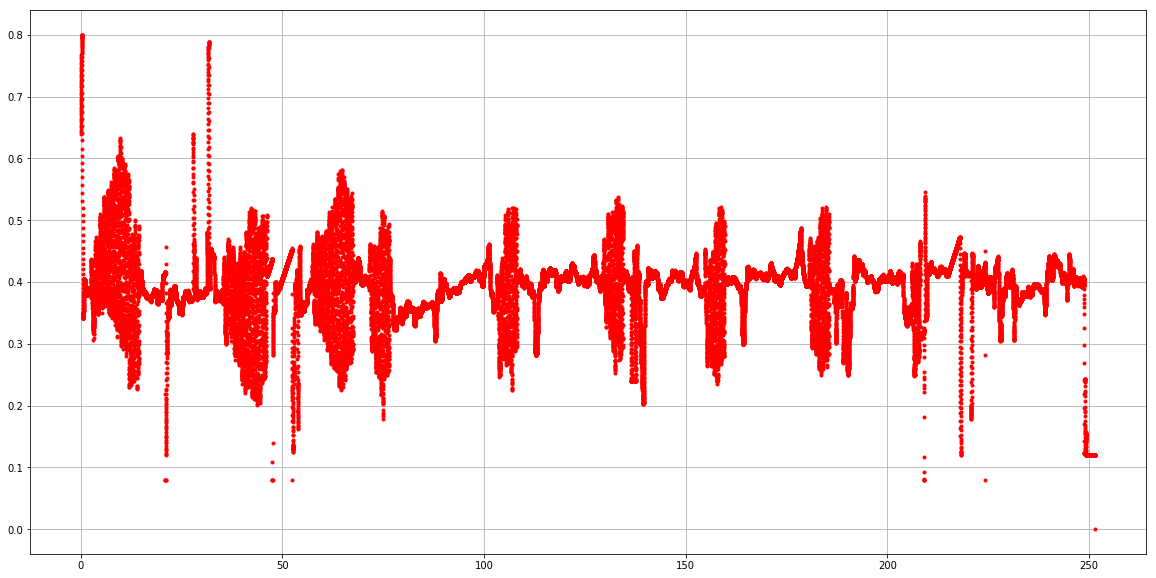

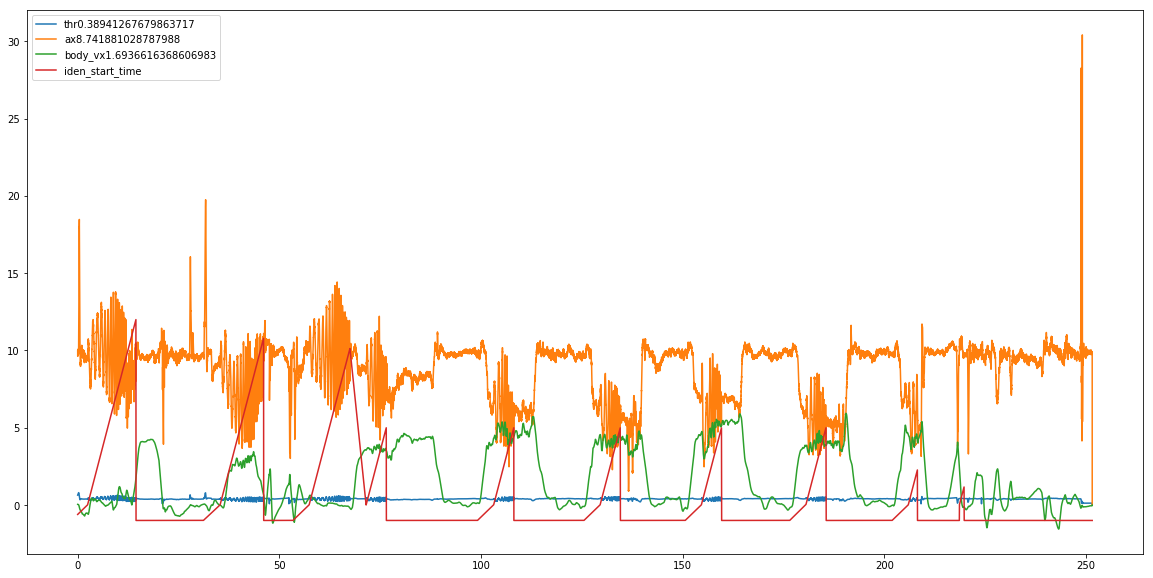

LOW
[0.00000000e+00 5.00008738e-03 1.00001748e-02 ... 5.29024245e+02
 5.29029245e+02 5.29034245e+02]


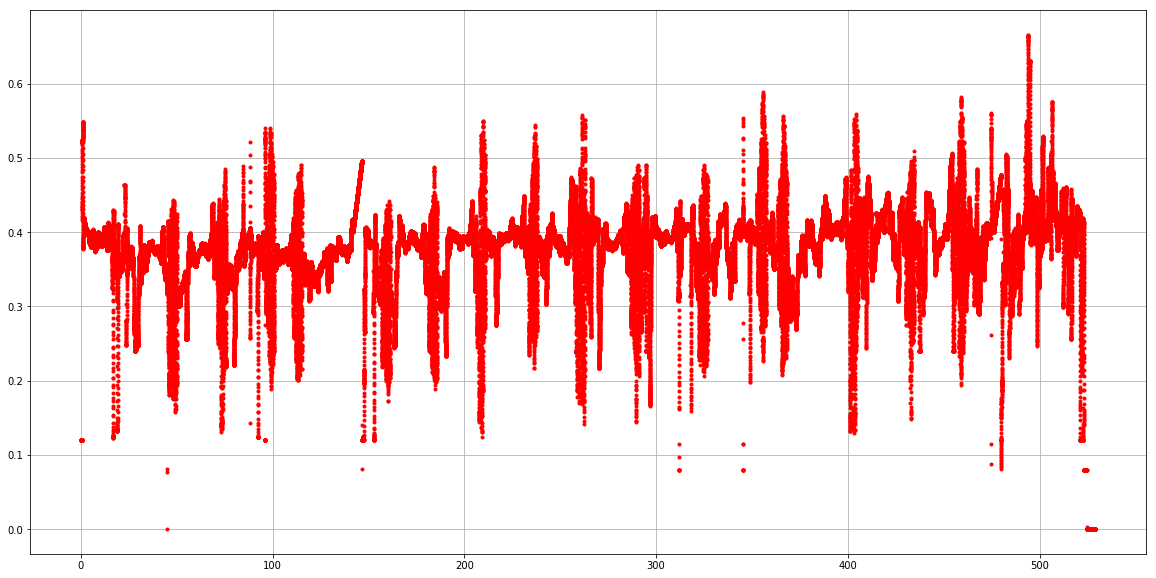

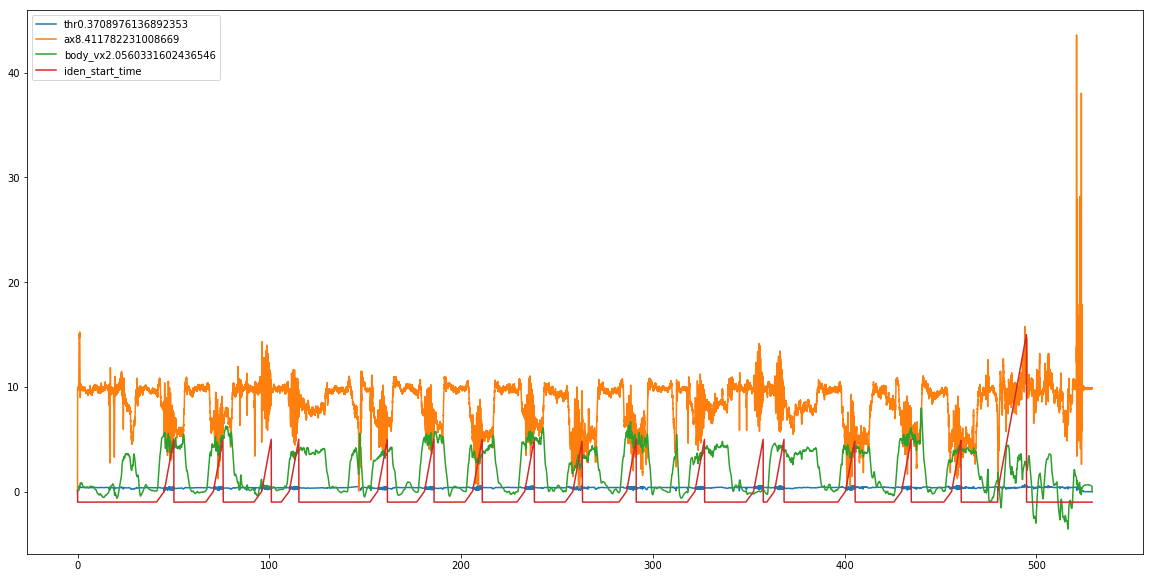

In [32]:
plt.rc('figure', figsize=(20.0, 10.0))
show_logs(px4_case)
show_logs(px4_case2)

Will start split data with ['iden_start_time']
Will start split data with ['iden_start_time']


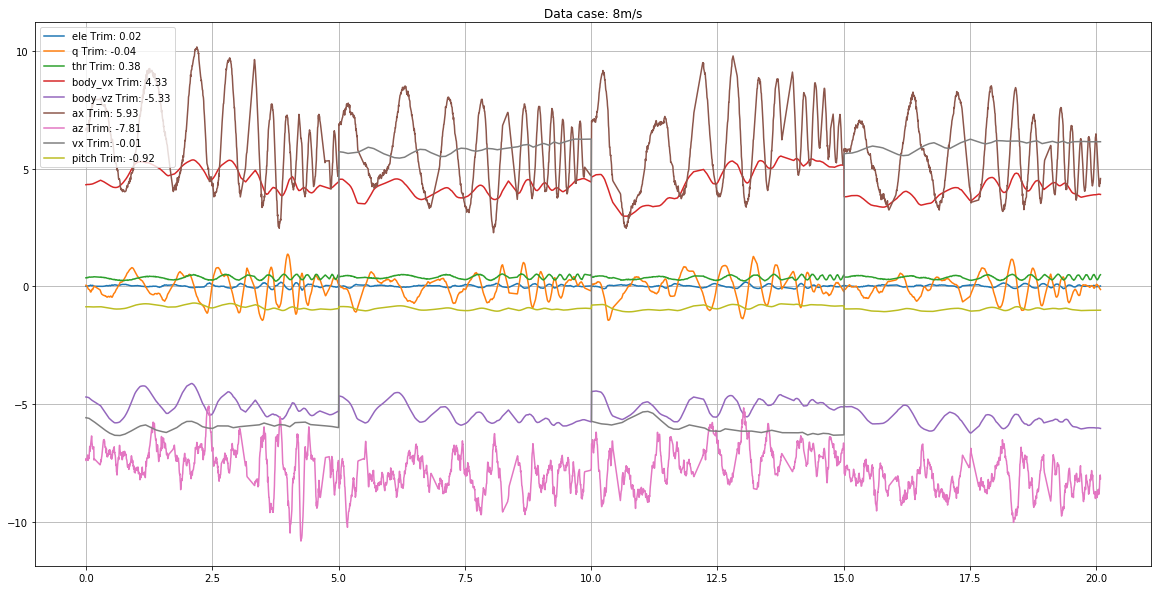

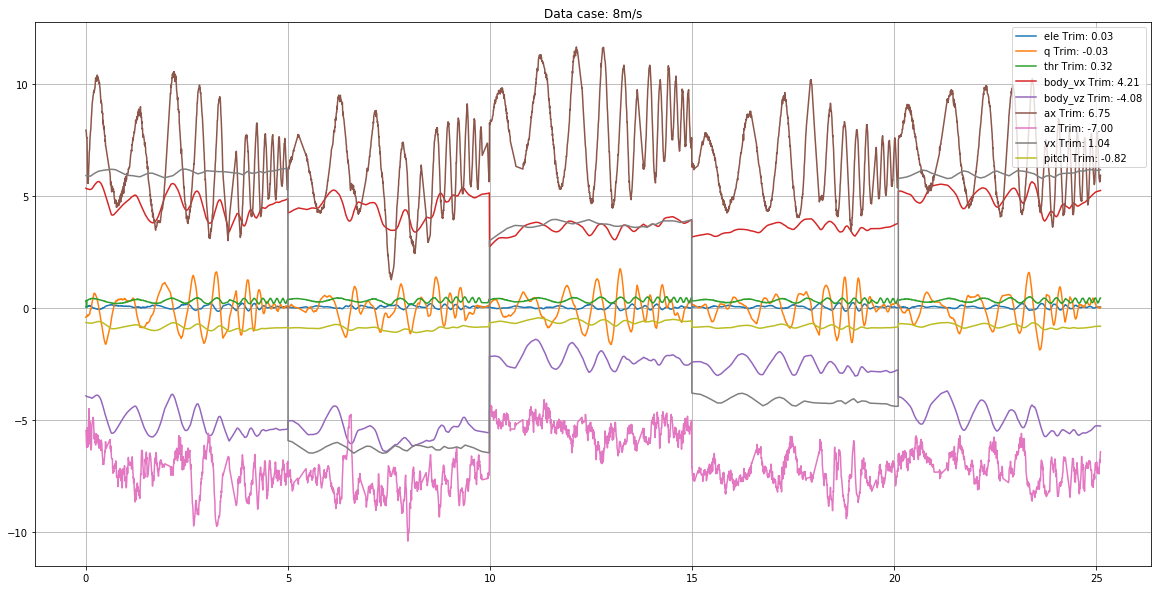

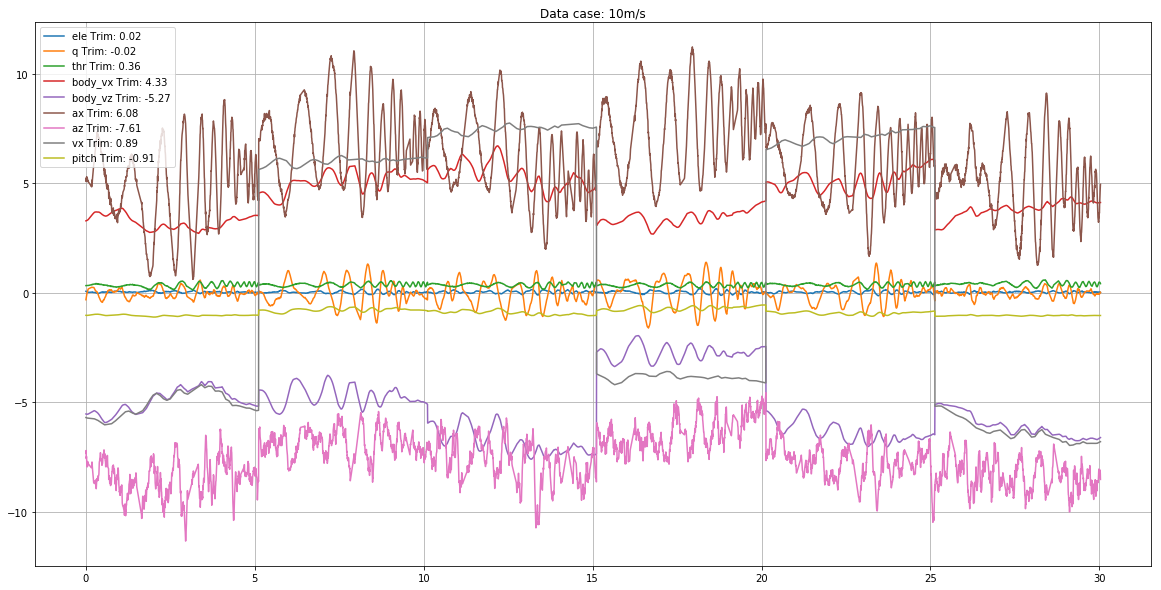

In [41]:
status = [
        "-","-","-","8m/s",
        "8m/s", "8m/s", "8m/s", "-", 
        "-"
]
status2 = [
    "8m/s","8m/s","-",#3
    "8m/s", "8m/s","8m/s",#5
    "10m/s", "10m/s", "-",
    "10m/s","10m/s","-","-",
    "-","10m/s","10m/s","-"
]


plt.rc('figure', figsize=(20.0, 10.0))
data_splited = split_logs(px4_case)
data_splited = join_data(data_splited, status)
data_splited2 = split_and_join_data(px4_case2, status2)
needed_data = ['ele', 'q', 'thr', "body_vx", "body_vz","ax","az","vx","pitch"]
plot_status_data(px4_case, data_splited,needed_data)
plot_status_data(px4_case2, data_splited2,needed_data)

In [53]:
idens_thrust = process_status_data(px4_case, data_splited, 5, 50)
idens_thrust.update(process_status_data(px4_case2, data_splited2, 5, 50))

Sample rate is 200.00000000000003
Sample rate is 200.00000000000003
Composite using [5, 7, 9, 11, 14]
Sample rate is 200.0
Sample rate is 200.0
Composite using [5, 8, 11, 14, 18]
Sample rate is 200.0
Sample rate is 200.0
Composite using [5, 9, 13, 17, 22]


In [55]:
idens_ax = process_status_data_q_to(px4_case, data_splited, 10, 30)
idens_ax.update(process_status_data_q_to(px4_case2, data_splited2, 10, 30))

Sample rate is 200.00000000000003
Sample rate is 200.00000000000003
Composite using [5, 5, 6, 7, 8]
Composite using [5, 5, 6, 7, 8]
Composite using [5, 5, 6, 7, 8]
Composite using [5, 5, 6, 7, 8]
Sample rate is 200.0
Sample rate is 200.0
Composite using [5, 6, 7, 8, 10]
Composite using [5, 6, 7, 8, 10]
Composite using [5, 6, 7, 8, 10]
Composite using [5, 6, 7, 8, 10]
Sample rate is 200.0
Sample rate is 200.0
Composite using [5, 7, 9, 11, 13]
Composite using [5, 7, 9, 11, 13]
Composite using [5, 7, 9, 11, 13]
Composite using [5, 7, 9, 11, 13]


C:\Users\plane\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


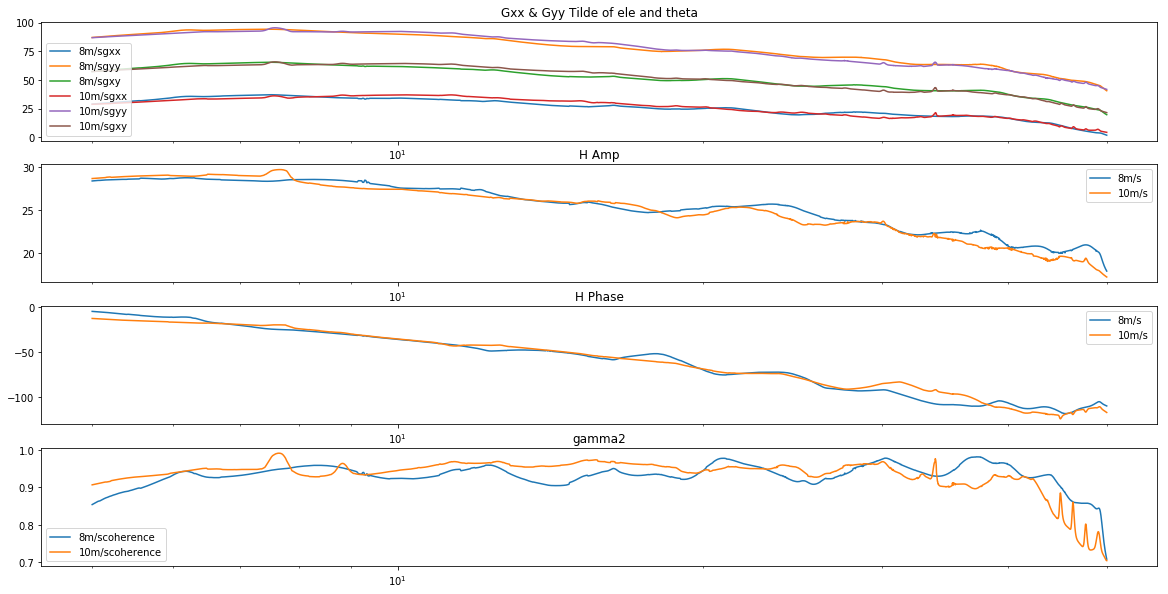

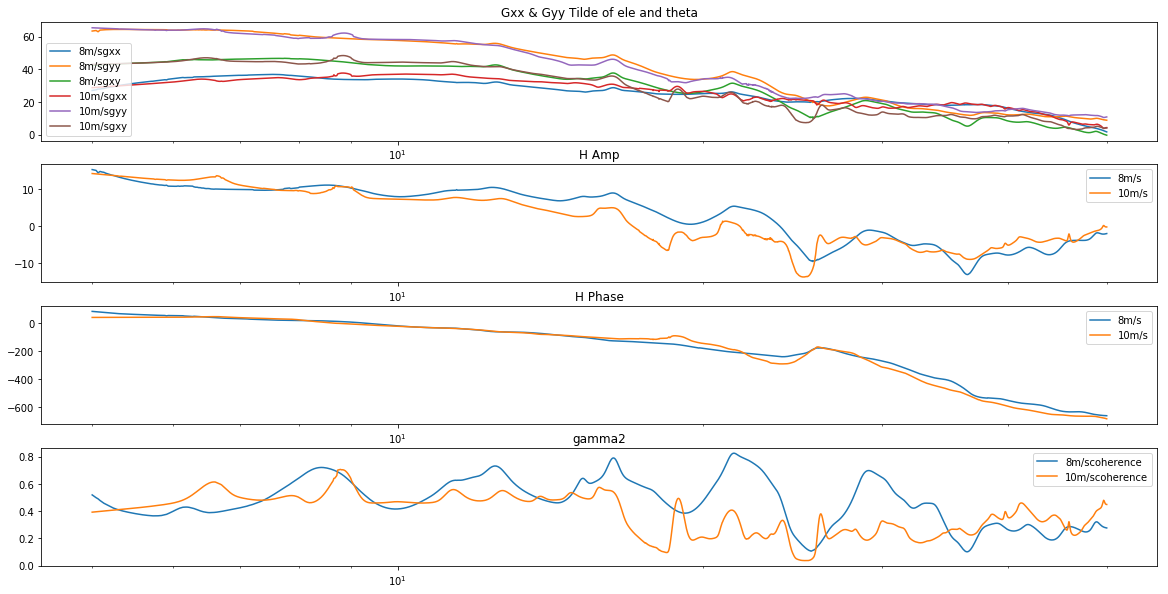

In [51]:
plt.rc('figure', figsize=(20.0, 10.0))
plot_idens_for_status(idens_thrust)

C:\Users\plane\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


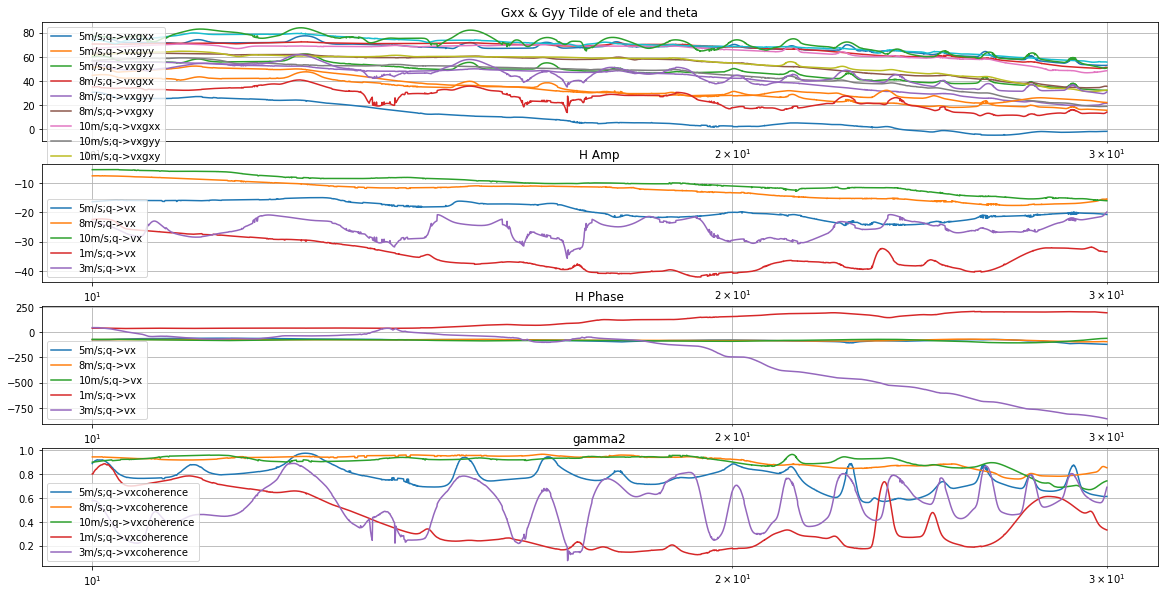

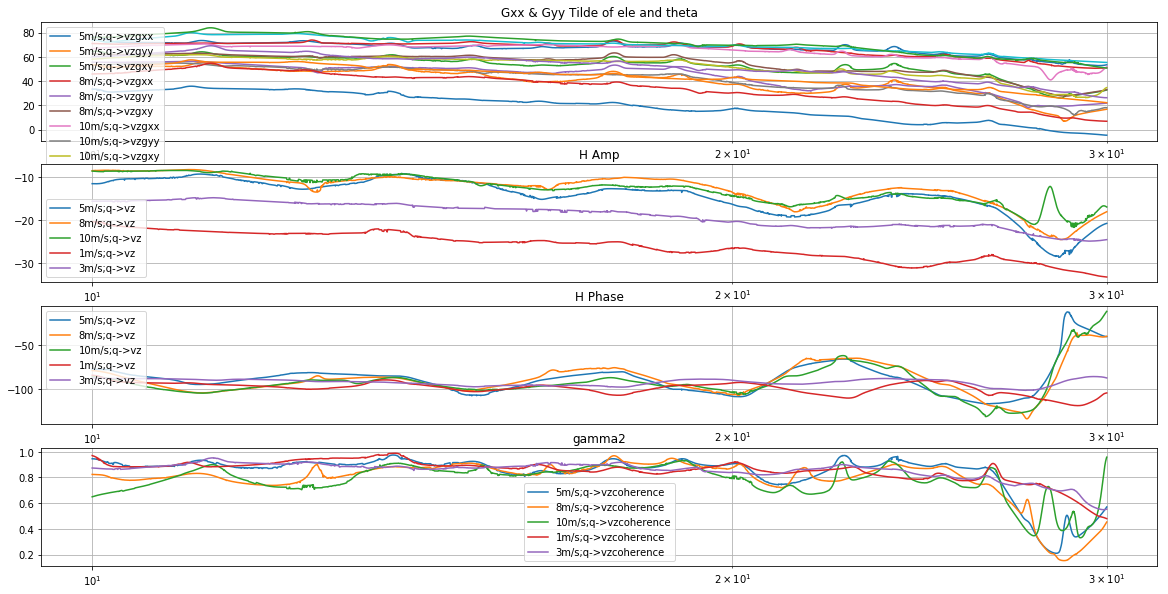

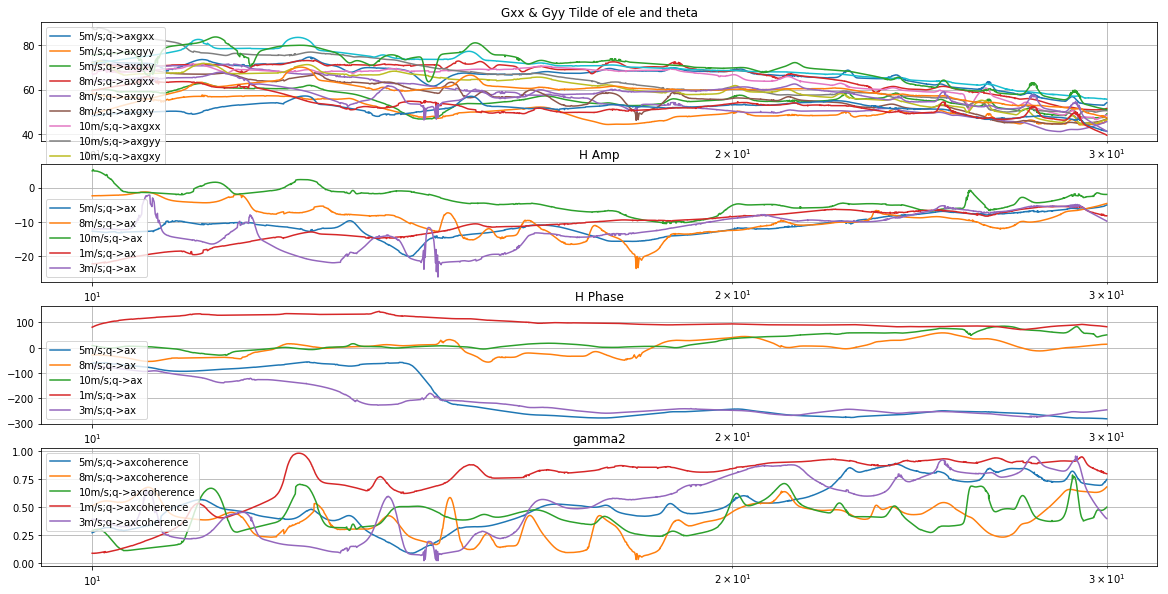

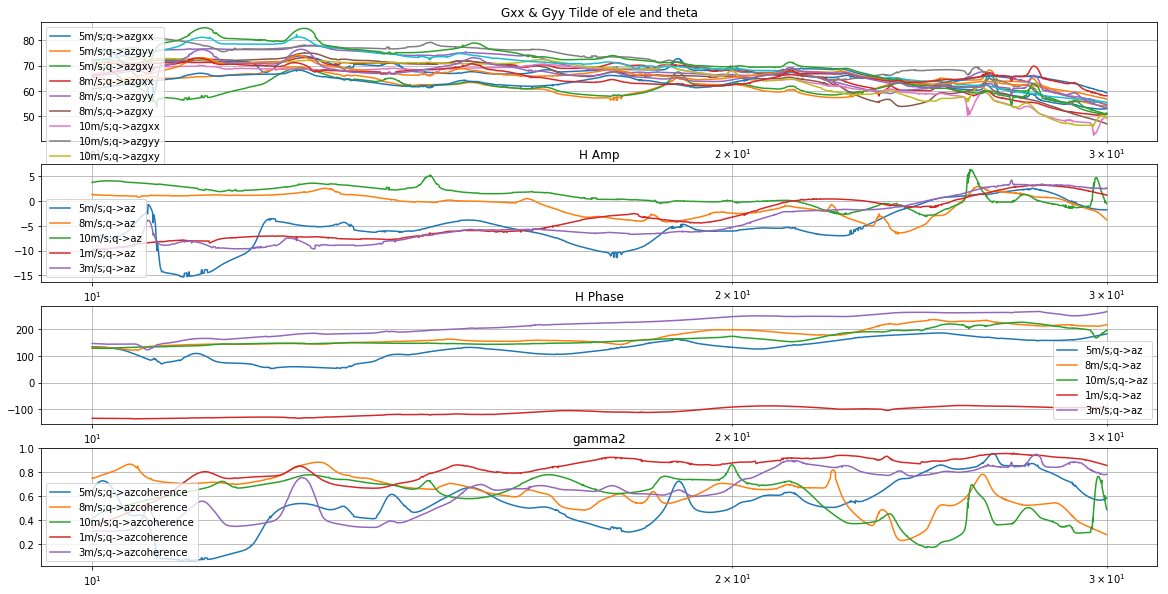

In [5]:
plt.rc('figure', figsize=(20.0, 10.0))
plot_idens_for_status_ax_to(idens_ax)

In [57]:
import pickle
pkl_name = "/Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/log_34_2018-5-29-freq-res-thrustax.pkl"
f = open(pkl_name,"wb")
pickle.dump(idens_thrust, f, pickle.HIGHEST_PROTOCOL)